# JET-ML MLBT vs MMAT – **v3.2 (GPU-ready, Mixed Precision, XLA)**

What’s new:
- Detects GPUs and enables **memory growth** to avoid OOM spikes.
- Optional **XLA** compilation and **mixed precision (fp16)** for speedups on supported GPUs.
- Uses `tf.distribute` strategy (multi-GPU ready). 
- Ensures the final output is computed in float32 when using mixed precision.

You can still flip all training toggles (model, resize, normalization, etc.).


In [17]:
# ============ 0) Global toggles ============
# Training pipeline options
AUGMENT = False              # True / False
MODEL_CHOICE = "VGG16"       # "VGG16" or "Small32CNN"
RESIZE_METHOD = "nearest"    # "nearest" or "bilinear" (VGG16 only)
NORM_MODE = "zscore"         # "imagenet" or "zscore"
VGG_WEIGHTS = "imagenet"     # "imagenet" or None
UNFREEZE_LAYERS = 12         # top-N VGG layers to unfreeze during fine-tune
HEAD_LR = 3e-4               # learning rate for head-only training
FT_LR = 1e-5                 # learning rate for fine-tuning
EPOCHS_HEAD = 30             # epochs for head-only
EPOCHS_FT = 10               # epochs for fine-tune
BATCH = 32
IMG_SIZE = 224               # for VGG16 path
USE_GROUPED_SPLIT = True     # stratify by (module, alpha_s, Q0)
USE_CLASS_WEIGHTS = True     # re-balance classes if needed
RUN_BASELINE = True          # logistic regression baseline
FINE_TUNE = True             # run fine-tuning phase if using VGG16
SAVE_BEST_PATH = "mlbt_mmat_v3p2_best.keras"

# GPU / performance toggles
ENABLE_XLA = True            # turn on XLA JIT if GPU present
USE_MIXED_PRECISION = True   # set global policy to 'mixed_float16' if GPU present
USE_DISTRIBUTED = True       # use MirroredStrategy if multiple GPUs


In [18]:
# 1) Clean logs + imports
import os
os.environ["TERM"] = "dumb"
os.environ["PYTHONIOENCODING"] = "UTF-8"
print("TERM =", os.environ.get("TERM"))

import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from collections import Counter

# Keras bits
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE


TERM = dumb
TensorFlow: 2.20.0


In [19]:
# 1.1) GPU setup (memory growth, XLA, mixed precision, strategy)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)

    if ENABLE_XLA:
        try:
            tf.config.optimizer.set_jit(True)  # Enable XLA
            print("XLA JIT enabled")
        except Exception as e:
            print("Could not enable XLA:", e)

    if USE_MIXED_PRECISION:
        try:
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy('mixed_float16')
            print("Mixed precision policy set to:", mixed_precision.global_policy().name)
        except Exception as e:
            print("Could not set mixed precision:", e)

    if USE_DISTRIBUTED and len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Using MirroredStrategy on {strategy.num_replicas_in_sync} replicas")
    else:
        strategy = tf.distribute.get_strategy()
        print("Using default strategy (single GPU or CPU)")
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU detected; using default (CPU) strategy")

print("GPUs detected:", gpus)
try:
    from tensorflow.keras import mixed_precision
    print("Current dtype policy:", mixed_precision.global_policy().name)
except Exception:
    pass


No GPU detected; using default (CPU) strategy
GPUs detected: []
Current dtype policy: float32


In [20]:
# 2) Load the dataset
pkl_path = "datasets\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_100000_shuffled.pkl"
with open(pkl_path, "rb") as f:
    X, y = pickle.load(f)

X = np.asarray(X)     # (N, 32, 32) float
y = np.asarray(y)     # (N, 3) strings: (module, alpha_s, Q0)

modules = y[:,0]                       # "MLBT" or "MMAT"
classes = (modules == "MLBT").astype(np.int32)  # 1=MLBT, 0=MMAT

alphas = y[:,1].astype(str)
q0s    = y[:,2].astype(str)

print("X shape:", X.shape)
print("Module counts:", Counter(modules))
print("Value ranges:", float(np.min(X)), "to", float(np.max(X)))


<>:2: SyntaxWarning: invalid escape sequence '\j'
<>:2: SyntaxWarning: invalid escape sequence '\j'
C:\Users\badenlt\AppData\Local\Temp\ipykernel_29292\1151767363.py:2: SyntaxWarning: invalid escape sequence '\j'
  pkl_path = "datasets\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_100000_shuffled.pkl"
C:\Users\badenlt\AppData\Local\Temp\ipykernel_29292\1151767363.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  X, y = pickle.load(f)


X shape: (100000, 32, 32)
Module counts: Counter({np.str_('MMAT'): 50180, np.str_('MLBT'): 49820})
Value ranges: 0.0 to 94.01920000000001


In [21]:
# 3) Train/Val split (optionally grouped by module+alpha+Q0)
if USE_GROUPED_SPLIT:
    groups = np.array([f"{m}_{a}_{q}" for m,a,q in zip(modules, alphas, q0s)])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(X, groups))
else:
    train_idx, val_idx = train_test_split(
        np.arange(len(X)), test_size=0.2, random_state=42, stratify=classes
    )

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = classes[train_idx], classes[val_idx]
mods_train = modules[train_idx]; mods_val = modules[val_idx]
a_train, a_val = alphas[train_idx], alphas[val_idx]
q_train, q_val = q0s[train_idx], q0s[val_idx]

print("Train counts:", Counter(y_train), "| Val counts:", Counter(y_val))


Train counts: Counter({np.int32(0): 40144, np.int32(1): 39856}) | Val counts: Counter({np.int32(0): 10036, np.int32(1): 9964})


In [22]:
# 4) Class weights (optional)
if USE_CLASS_WEIGHTS:
    from sklearn.utils.class_weight import compute_class_weight
    uniq = np.unique(y_train)
    cw = compute_class_weight(class_weight="balanced", classes=uniq, y=y_train)
    CLASS_WEIGHT = {int(k): float(v) for k,v in zip(uniq, cw)}
else:
    CLASS_WEIGHT = None
print("Class weights:", CLASS_WEIGHT)


Class weights: {0: 0.9964129135113591, 1: 1.0036130068245686}


In [23]:
# 5) Normalization helpers
SCALE_TO_255 = (float(np.max(X_train)) <= 1.5)  # approximate [0,1]
MEAN = float(np.mean(X_train))
STD  = float(np.std(X_train) + 1e-8)
print("SCALE_TO_255:", SCALE_TO_255, "| MEAN/STD:", MEAN, STD)

def resize_3ch(x):
    x = tf.expand_dims(x, -1)         # (H,W,1)
    x = tf.repeat(x, 3, -1)           # (H,W,3)
    method = "nearest" if RESIZE_METHOD == "nearest" else "bilinear"
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), method=method)
    x = tf.cast(x, tf.float32)
    return x

def preprocess_vgg(x):
    x = resize_3ch(x)
    if NORM_MODE == "imagenet":
        x = x * 255.0 if SCALE_TO_255 else x
        x = preprocess_input(x)
    else:
        x = (x - MEAN) / STD
    return x

def preprocess_32x32(x):
    x = tf.expand_dims(x, -1)  # (32,32,1)
    x = tf.cast(x, tf.float32)
    if NORM_MODE == "imagenet":
        x = x * 255.0 if SCALE_TO_255 else x
    else:
        x = (x - MEAN) / STD
    return x


SCALE_TO_255: False | MEAN/STD: 0.09094801629376695 1.2349703992914058


In [24]:
# 6) tf.data datasets
def make_ds(X_arr, y_arr, training=True):
    if MODEL_CHOICE == "VGG16":
        def _map(x, y): return preprocess_vgg(x), y
    else:
        def _map(x, y): return preprocess_32x32(x), y

    ds = tf.data.Dataset.from_tensor_slices((X_arr, y_arr)).map(_map, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
        if AUGMENT and MODEL_CHOICE == "VGG16":
            aug = tf.keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.05),
                layers.RandomZoom(0.1),
            ])
            def _aug(x, y): return aug(x), y
            ds = ds.map(_aug, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)


In [25]:
# 7) Baseline logistic regression
if RUN_BASELINE:
    from sklearn.linear_model import LogisticRegression
    Xtr_flat = X_train.reshape((X_train.shape[0], -1))
    Xva_flat = X_val.reshape((X_val.shape[0], -1))
    if NORM_MODE == "imagenet" and not SCALE_TO_255:
        scale = float(np.max(X_train))
        Xtr_bl, Xva_bl = Xtr_flat/scale, Xva_flat/scale
    else:
        Xtr_bl, Xva_bl = Xtr_flat, Xva_flat
    lr = LogisticRegression(max_iter=2000, class_weight="balanced" if USE_CLASS_WEIGHTS else None)
    lr.fit(Xtr_bl, y_train)
    y_pred_bl = lr.predict(Xva_bl)
    print("Baseline logistic accuracy:", accuracy_score(y_val, y_pred_bl))


Baseline logistic accuracy: 0.86455


In [26]:
# 8) Model builders (ensure float32 output when using mixed precision)
def float32_head(x):
    # Ensures final dense runs in float32 for numerical stability with mixed precision
    x = layers.Dense(1, activation="sigmoid", dtype="float32")(x)
    return x

def build_vgg16():
    base = VGG16(include_top=False, weights=VGG_WEIGHTS, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base.layers:
        layer.trainable = False
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = float32_head(x)
    model = Model(inputs, outputs)
    return model, base

def build_small32():
    inputs = layers.Input(shape=(32,32,1))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = float32_head(x)
    model = Model(inputs, outputs)
    return model


In [27]:
# 9) Compile + train (head) under strategy.scope()
with strategy.scope():
    if MODEL_CHOICE == "VGG16":
        model, base = build_vgg16()
    else:
        model = build_small32()

    model.compile(optimizer=tf.keras.optimizers.Adam(HEAD_LR),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

cbs = [
    ModelCheckpoint(SAVE_BEST_PATH, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1, min_lr=1e-6),
]

history = model.fit(
    train_ds,
    epochs=EPOCHS_HEAD,
    validation_data=val_ds,
    callbacks=cbs,
    verbose=1,
    class_weight={0:1.0, 1:1.0} if CLASS_WEIGHT is None else CLASS_WEIGHT
)


Epoch 1/30
  37/2500 ━━━━━━━━━━━━━━━━━━━━ 1:57:55 3s/step - accuracy: 0.4935 - auc: 0.4877 - loss: 0.7488

KeyboardInterrupt: 

In [ ]:
# 10) Optional fine-tuning for VGG16 (within scope)
if MODEL_CHOICE == "VGG16" and FINE_TUNE:
    with strategy.scope():
        for layer in base.layers[-UNFREEZE_LAYERS:]:
            layer.trainable = True
        model.compile(optimizer=tf.keras.optimizers.Adam(FT_LR),
                      loss="binary_crossentropy",
                      metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    history_ft = model.fit(
        train_ds,
        epochs=EPOCHS_FT,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=1,
        class_weight={0:1.0, 1:1.0} if CLASS_WEIGHT is None else CLASS_WEIGHT
    )


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6360 - auc: 0.7036 - loss: 0.6304
Epoch 1: val_accuracy did not improve from 0.73500
25/25 ━━━━━━━━━━━━━━━━━━━━ 267s 11s/step - accuracy: 0.6400 - auc: 0.6920 - loss: 0.6273 - val_accuracy: 0.7200 - val_auc: 0.7528 - val_loss: 0.5659 - learning_rate: 1.0000e-05
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6636 - auc: 0.7243 - loss: 0.5936
Epoch 2: val_accuracy did not improve from 0.73500
25/25 ━━━━━━━━━━━━━━━━━━━━ 260s 10s/step - accuracy: 0.6963 - auc: 0.7461 - loss: 0.5700 - val_accuracy: 0.6950 - val_auc: 0.7728 - val_loss: 0.5292 - learning_rate: 1.0000e-05
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7196 - auc: 0.8063 - loss: 0.5196 
Epoch 3: val_accuracy did not improve from 0.73500
25/25 ━━━━━━━━━━━━━━━━━━━━ 278s 11s/step - accuracy: 0.7312 - auc: 0.8155 - loss: 0.5155 - val_accuracy: 0.7150 - val_auc: 0.8207 - val_loss: 0.5342 - learning_rate: 1.0000e-05
Epoch 4/10
25/25 ━━━━

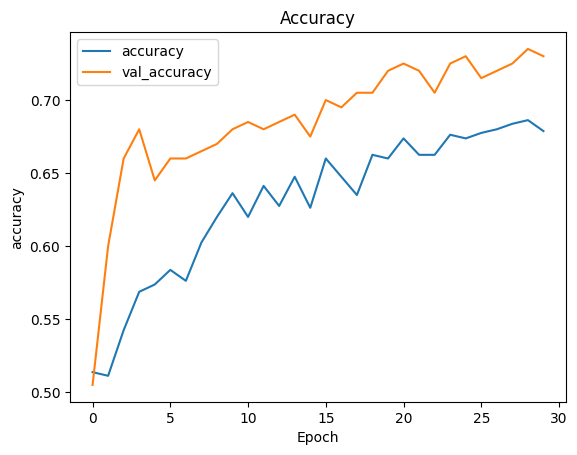

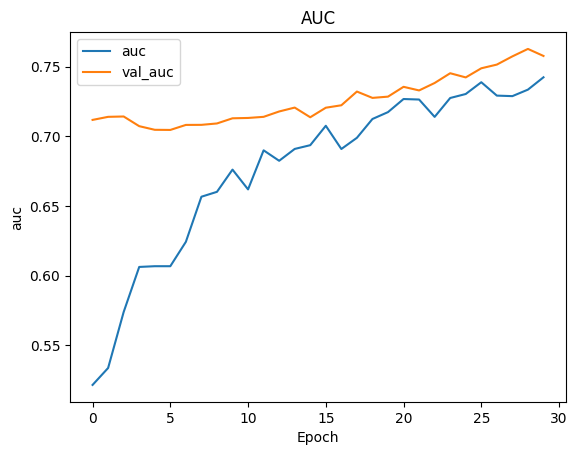

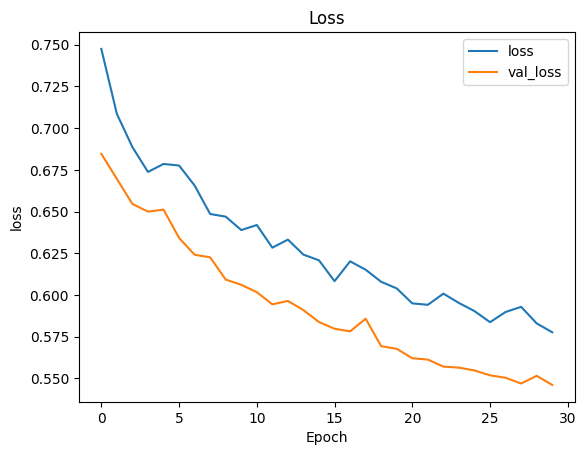

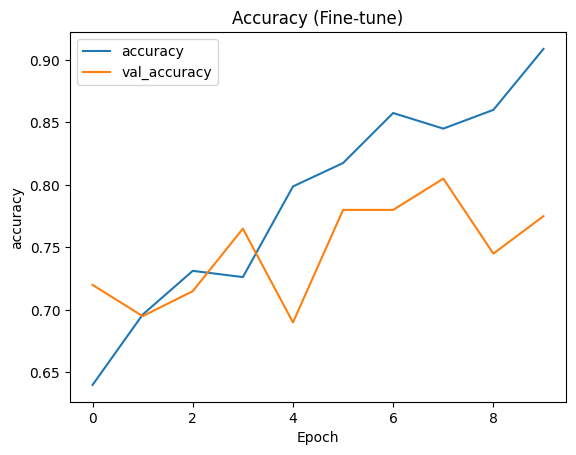

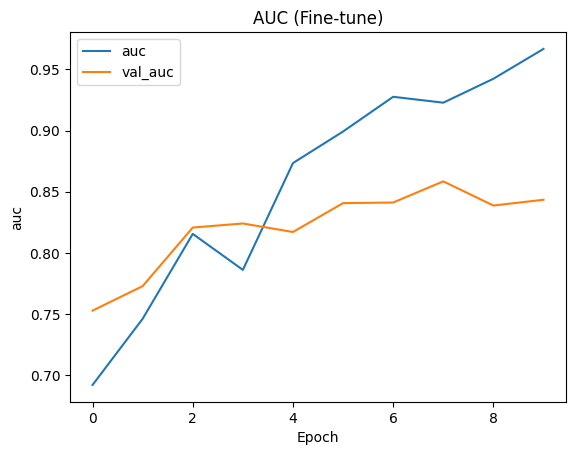

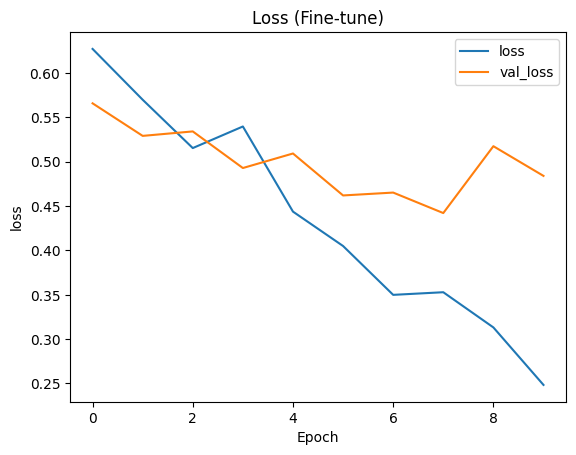

In [ ]:
# 11) Training curves (accuracy, AUC, loss)
def plot_metric(hist, key, val_key=None, title=None):
    if val_key is None:
        val_key = "val_" + key
    h = hist.history
    if key in h and val_key in h:
        plt.figure()
        plt.plot(h[key], label=key)
        plt.plot(h[val_key], label=val_key)
        plt.title(title if title else key)
        plt.xlabel("Epoch")
        plt.ylabel(key)
        plt.legend()
        plt.show()

plot_metric(history, "accuracy", "val_accuracy", "Accuracy")
plot_metric(history, "auc", "val_auc", "AUC")
plot_metric(history, "loss", "val_loss", "Loss")

try:
    plot_metric(history_ft, "accuracy", "val_accuracy", "Accuracy (Fine-tune)")
    plot_metric(history_ft, "auc", "val_auc", "AUC (Fine-tune)")
    plot_metric(history_ft, "loss", "val_loss", "Loss (Fine-tune)")
except NameError:
    pass


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step


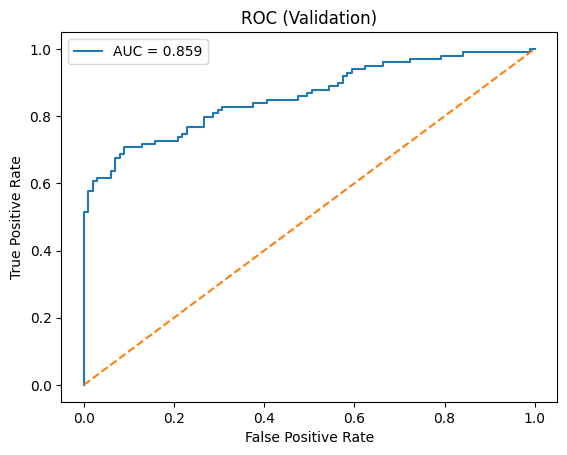

In [ ]:
# 12) ROC curve (validation)
y_prob = model.predict(val_ds).ravel()
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Validation)")
plt.legend()
plt.show()


Confusion matrix:
 [[92  9]
 [30 69]]


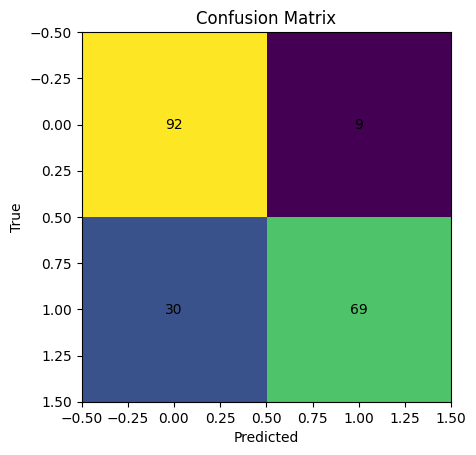


Classification report (1=MLBT, 0=MMAT):
              precision    recall  f1-score   support

        MMAT       0.75      0.91      0.83       101
        MLBT       0.88      0.70      0.78        99

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.80       200
weighted avg       0.82      0.81      0.80       200



In [ ]:
# 13) Confusion matrix & report
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.show()

print("\nClassification report (1=MLBT, 0=MMAT):")
print(classification_report(y_val, y_pred, target_names=["MMAT", "MLBT"]))


In [ ]:
# === Save the trained model ===
save_path = "mlbt_mmat_final_model.keras"   # or .h5 if you prefer legacy format
model.save(save_path)
print(f"Model saved to: {save_path}")


Model saved to: mlbt_mmat_final_model.keras
